# IMDB影評分析
IMDB網路資料庫是一個電影相關的線上資料庫，開始於 1990 年，共收錄了四百多萬作品資料，涵蓋 50000 筆 "影評文字”，每一筆 "影評文字" 都被標記成 "正面評價" 或 "負面評價”  。情緒分析是使用 "自然語言處理" 、文字分析等方法，找出作者表達中的評價或情緒，應用的領域十分多元及富含商業價值，如：可用來提早得知顧客對公司或產品觀感，以即時調整銷售策略方向。

### 環境提醒及備註
在執行本專案前請先確認Jupyter筆記本設置是否正確，首先點選主選單的「修改」─「筆記本設置」─「運行類別」，選擇「Python3」，同時將「硬件加速器」下拉式選單由「None」改成「GPU」，再按「保存」。

### 架構
建立一個模型，經過大量 "影評文字" 訓練後，此模型能用於預測 "影評文字" 的評價，主要包括下面四個步驟：
>1.   進行資料前處理(Processing)

>2.   建構深度學習模型(Model)

>3.   訓練及驗證模型準確度(Validation Accuracy)

>4.   評估模型的學習狀況(Inference)

In [41]:
# 1-1
# 載入所需套件
import json
# 資料處理套件
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# 檔案路徑處理套件
import urllib.request # 判斷檔案是否存在
import os # 開啟壓縮檔
import tarfile # 解壓縮檔案至指定目錄

# 深度學習套件
import tensorflow as tf
from keras.preprocessing import sequence # 截長補短
from keras.preprocessing.text import Tokenizer  # 建立字典from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation,Flatten
from keras.layers import BatchNormalization, LeakyReLU
from keras.layers.embeddings import Embedding # 詞向量
from keras import regularizers
from keras.models import Sequential

---

**1.1 下載資料集**

---

In [2]:
# 1-2

url="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz" # 資料集網址  
filepath = "data/aclImdb_v1.tar.gz" # 設定資料夾路徑
if not os.path.isfile(filepath): # 判斷檔案是否存在，如果不存在就下載
    result = urllib.request.urlretrieve(url, filepath)  
    print('download: ',result) 

In [3]:
# 1-2

if not os.path.exists("data/aclImdb"): # 判斷檔案是否存在
    tfile = tarfile.open("data/aclImdb_v1.tar.gz" , 'r:gz') # 開啟壓縮檔
    result = tfile.extractall('data/') # 解壓縮檔案至指定目錄

---

**1.2 資料前處理**

---

In [4]:
# 1-3
# 用正規表示式移除HTML tag

import re  # 匯入regular expression 模組
def rm_tags(text):  # 建立rm_tags函數，輸入參數text
    re_tag = re.compile(r'<[^>]+>')  # 建立re_tag正規表示式變數為'<[^>]+>'
    return re_tag.sub('',text)  # 使用re_tag將text文字中，符合正規表示式條件的字變成空字串

In [5]:
# 1-4

def read_files(filetype): # 建立read_files函數，輸入filetype參數
    path = "data/aclImdb/" # 設定存取檔案路徑
    file_list=[] # 建立檔案list

    positive_path=path + filetype+"/pos/" # 設定正面評價檔案目錄positive_path
    for f in os.listdir(positive_path):  # 利用for迴圈將positive_path中的檔案加入file_list
        file_list+=[positive_path+f]
    
    negative_path=path + filetype+"/neg/"  # 設定負面評價檔案目錄negative_path
    for f in os.listdir(negative_path):  # 利用for迴圈將negative_path中的檔案加入file_list
        file_list+=[negative_path+f]
        
    print('read',filetype, 'files:',len(file_list)) # 顯示目前讀取的filetype目錄下檔案的個數
       
    all_labels = ([1] * 12500 + [0] * 12500) 
    
    all_texts  = []
    for fi in file_list:  # fi讀取file_list檔案
        with open(fi,encoding='utf8') as file_input:  # 使用open(fi,encoding='utf8')讀取檔案為file_input
            all_texts += [rm_tags(" ".join(file_input.readlines()))]  # 使用file_input.readlines()讀取檔案，並使用join連結所有檔案內容，然後使用rm_tags移除tag最後加入all_texts list
            
    return all_labels,all_texts  # 傳回all_labels,all_texts

In [6]:
# 1-5

def save_train(file):
    for i in range(12500):
        fp =  open(file[i],'w')

In [7]:
# 1-6
# 使用read_files傳入train參數，讀取訓練資料

y_train,train_text=read_files("train") 

read train files: 25000


In [8]:
# 1-7
# 使用read_files傳入test參數 讀取測試資料

y_test,test_text=read_files("test") 

read test files: 25000


In [9]:
# 1-8

train_text[0]

'Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High\'s satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers\' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I\'m here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn\'t!'

In [10]:
# 1-9
# 結果是1表示為正面評價

y_train[0] 

1

---

**1.3 建立訓練數據集**

---

In [11]:
# 1-10
# 建立一個3500個字的字典
# 讀取訓練及資料影評，排序前3500的英文字會列入字典

token = Tokenizer(num_words=3500)  
token.fit_on_texts(train_text)
tokenWords = token.word_index
stopWords = ['just',"it's",'really',"don't",'did','does',"i'm",'real',"doesn't","did't",'10',"can't","that's","i've","isn't","he's",'2',"wasn't",'1','3','a','i','about','above','across','after','afterwards','again','against','all','almost','alone','along','already','also','although','always','am','among','amongst','amount','an','and','another','any','anyhow','anyone','anything','anyway','anywhere','are','around','as','at','back','be','became','because','become','becomes','becoming','been','before','beforehand','behind','being','below','beside','besides','between','beyond','bill','both','bottom','but','by','call','can','cannot','cant','co','con','could','couldnt','cry','de','describe','detail','do','done','down','due','during','each','eg','eight','either','eleven','else','elsewhere','empty','enough','etc','even','ever','every','everyone','everything','everywhere','except','few','fifteen','fill','find','fire','first','five','for','former','formerly','forty','found','four','from','front','full','further','get','give','go','had','has','hasnt','have','he','hence','her','here','hereafter','hereby','herein','hers','herself','him','himself','his','how','however','hundred','ie','if','in','inc','indeed','interest','into','is','it','its','itself','keep','last','latter','least','less','ltd','made','many','may','me','meanwhile','might','mill','mine','more','moreover','most','mostly','move','much','must','my','myself','name','namely','neither','never','nevertheless','next','nine','no','nobody','none','noone','nor','not','nothing','now','nowhere','of','off','often','on','once','one','only','onto','or','other','others','otherwise','our','ours','ourselves','out','over','own','part','per','perhaps','please','put','rather','re','same','see','seem','seemed','seeming','seems','serious','several','she','should','show','side','since','sincere','six','sixty','so','some','somehow','someone','something','sometime','sometimes','somewhere','still','such','system','take','ten','than','that','the','their','them','themselves','then','thence','there','thereafter','thereby','therefore','therein','these','they','thick','thin','third','this','those','though','three','through','throughout','thru','thus','to','together','too','top','toward','towards','twelve','twenty','two','un','under','until','up','upon','us','very','via','was','we','well','were','what','whatever','when','whence','whenever','where','whereas','whereby','wherein','whereupon','wherever','whether','which','while','whither','who','whoever','whole','whom','whose','why','will','with','within','without','would','yet','you','your','yours','yourself']
[tokenWords.pop(key) for key in stopWords]

[39,
 41,
 62,
 88,
 118,
 123,
 142,
 143,
 148,
 30201,
 160,
 187,
 194,
 203,
 214,
 236,
 237,
 281,
 301,
 339,
 3,
 9,
 40,
 748,
 634,
 99,
 3493,
 170,
 425,
 28,
 216,
 580,
 363,
 454,
 77,
 258,
 206,
 240,
 787,
 2979,
 1162,
 31,
 2,
 155,
 97,
 6405,
 255,
 228,
 549,
 1760,
 22,
 183,
 13,
 29,
 141,
 25,
 873,
 83,
 409,
 455,
 1568,
 73,
 154,
 7871,
 491,
 108,
 1904,
 5595,
 1366,
 196,
 720,
 984,
 195,
 1330,
 17,
 30,
 679,
 66,
 561,
 2494,
 997,
 2700,
 96,
 24561,
 1408,
 848,
 1632,
 1584,
 78,
 220,
 176,
 684,
 311,
 253,
 10996,
 2312,
 341,
 6000,
 331,
 3298,
 1899,
 191,
 520,
 56,
 122,
 171,
 312,
 282,
 2574,
 545,
 167,
 3514,
 2227,
 165,
 962,
 82,
 672,
 14,
 1135,
 10621,
 4203,
 254,
 685,
 35,
 1004,
 364,
 1031,
 74,
 198,
 136,
 65,
 43,
 52479,
 24,
 26,
 3035,
 37,
 129,
 29752,
 39150,
 11339,
 6116,
 760,
 86,
 305,
 23,
 85,
 186,
 3130,
 6007,
 44,
 7,
 9311,
 845,
 598,
 79,
 6,
 8,
 90,
 406,
 397,
 232,
 1565,
 218,
 324,
 66863,
 8

In [12]:
# 1-11

print(token.document_count)

25000


In [13]:
# 1-12

#print(token.word_index)

#with open('tokenWords.json', 'w') as file:
    #file.write(json.dumps(token.word_index))

In [14]:
# 1-13

x_train_seq = token.texts_to_sequences(train_text)
x_test_seq = token.texts_to_sequences(test_text)

In [15]:
# 1-14

print(train_text[0])

Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I'm here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn't!


In [16]:
# 1-15

print(x_train_seq[0])

[308, 1068, 208, 2160, 54, 391, 109, 149, 481, 260, 2000, 2422, 631, 2001, 1530, 204, 1229, 899, 3021, 693, 1530, 215, 386, 1470, 798, 391, 1235, 308, 352, 343, 2970, 1470, 2372, 308, 532, 1466, 554, 100, 308, 226, 2231]


In [17]:
# 1-16
# 100為數字list長度 可以修改

x_train = sequence.pad_sequences(x_train_seq,maxlen=350)  
x_test = sequence.pad_sequences(x_test_seq,maxlen=350)

In [18]:
# 1-17

print('before pad_sequences length=',len(x_train_seq[1]))
print(x_train_seq[1])

before pad_sequences length= 123
[739, 3413, 1828, 149, 1338, 335, 886, 1190, 402, 166, 391, 153, 2304, 546, 80, 100, 3263, 412, 1199, 179, 3080, 321, 358, 3107, 2126, 126, 1980, 344, 2128, 408, 1980, 3229, 340, 719, 725, 1264, 1506, 1220, 2523, 36, 3263, 2030, 3208, 379, 294, 1022, 128, 178, 93, 2128, 2995, 408, 1980, 3247, 499, 2875, 490, 701, 1181, 227, 1367, 886, 1483, 344, 394, 888, 101, 582, 251, 1956, 1230, 3183, 184, 2320, 340, 2223, 2600, 338, 1980, 502, 338, 36, 1022, 544, 2812, 511, 551, 115, 2015, 1660, 110, 109, 104, 2587, 208, 283, 1074, 2750, 153, 181, 546, 36, 256, 2320, 247, 503, 227, 374, 2128, 36, 1022, 80, 120, 274, 275, 3263, 300, 767, 36, 274, 275, 18, 335]


In [19]:
# 1-18

print('after pad_sequences length=',len(x_train[1]))
print(x_train[1])

after pad_sequences length= 350
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0

In [20]:
# 1-19

print('before pad_sequences length=',len(x_train_seq[0]))
print(x_train_seq[1])

before pad_sequences length= 41
[739, 3413, 1828, 149, 1338, 335, 886, 1190, 402, 166, 391, 153, 2304, 546, 80, 100, 3263, 412, 1199, 179, 3080, 321, 358, 3107, 2126, 126, 1980, 344, 2128, 408, 1980, 3229, 340, 719, 725, 1264, 1506, 1220, 2523, 36, 3263, 2030, 3208, 379, 294, 1022, 128, 178, 93, 2128, 2995, 408, 1980, 3247, 499, 2875, 490, 701, 1181, 227, 1367, 886, 1483, 344, 394, 888, 101, 582, 251, 1956, 1230, 3183, 184, 2320, 340, 2223, 2600, 338, 1980, 502, 338, 36, 1022, 544, 2812, 511, 551, 115, 2015, 1660, 110, 109, 104, 2587, 208, 283, 1074, 2750, 153, 181, 546, 36, 256, 2320, 247, 503, 227, 374, 2128, 36, 1022, 80, 120, 274, 275, 3263, 300, 767, 36, 274, 275, 18, 335]


In [21]:
# 1-20

print('after pad_sequences length=',len(x_train[0]))
print(x_train[0])

after pad_sequences length= 350
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0

---

**1.4 建立深度學習模型**

---

In [60]:
# 1-21

model = Sequential()

In [61]:
# 1-22
# 將『數字list』轉為32維度的向量
# 建立3500維度的向量
# list每筆為350個字 
# 加入Dropout避免overfitting

model.add(Embedding(output_dim=32, input_dim=3500, input_length=350)) # (2000是輸入維度，100是數字list長度)
model.add(BatchNormalization())  

In [62]:
# 1-23

model.add(Flatten())

In [63]:
# 1-24
# 隱藏層有256個神經元
# 定義激活函數
# 加入Dropout避免overfitting

model.add(Dense(units=256, activation = LeakyReLU(), kernel_regularizer=regularizers.l2(0.05)))
model.add(BatchNormalization())

C:\Users\Yu\AppData\Roaming\Python\Python37\site-packages\keras\activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [64]:
# 1-25
# 輸出層有1個神經元
# 定義激活函數

model.add(Dense(units=1,activation='sigmoid' ))

In [65]:
# 1-26

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 350, 32)           112000    
_________________________________________________________________
batch_normalization_7 (Batch (None, 350, 32)           128       
_________________________________________________________________
flatten_2 (Flatten)          (None, 11200)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               2867456   
_________________________________________________________________
batch_normalization_8 (Batch (None, 256)               1024      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 2,980,865
Trainable params: 2,980,289
Non-trainable params: 576
__________________________________________

In [66]:
# 1-27
# 設定損失函數
# 設定最優化的訓練方法
# 設定評估模型方式

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [67]:
# 1-28

from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=2)

In [68]:
# 1-29
# 設定訓練參數
# 設定每一次訓練幾筆資料
# 設定執行幾次週期
# 顯示訓練過程
# 設定訓練與驗證資料比例
train_history = model.fit ( x_train , y_train , batch_size=32 , epochs=10 , verbose=2 , validation_split=0.25)                  

Train on 18750 samples, validate on 6250 samples
Epoch 1/10
 - 38s - loss: 1.6408 - accuracy: 0.7715 - val_loss: 1.1624 - val_accuracy: 0.6102
Epoch 2/10
 - 37s - loss: 0.6911 - accuracy: 0.8685 - val_loss: 1.2556 - val_accuracy: 0.5250
Epoch 3/10
 - 36s - loss: 0.6410 - accuracy: 0.8983 - val_loss: 0.9823 - val_accuracy: 0.7606
Epoch 4/10
 - 36s - loss: 0.6116 - accuracy: 0.9230 - val_loss: 0.9171 - val_accuracy: 0.8310
Epoch 5/10
 - 36s - loss: 0.5549 - accuracy: 0.9406 - val_loss: 1.2433 - val_accuracy: 0.7216
Epoch 6/10
 - 38s - loss: 0.4973 - accuracy: 0.9558 - val_loss: 1.1271 - val_accuracy: 0.7856
Epoch 7/10
 - 36s - loss: 0.4171 - accuracy: 0.9643 - val_loss: 1.1756 - val_accuracy: 0.7219
Epoch 8/10
 - 36s - loss: 0.3978 - accuracy: 0.9724 - val_loss: 1.6516 - val_accuracy: 0.6573
Epoch 9/10
 - 36s - loss: 0.3745 - accuracy: 0.9753 - val_loss: 1.2523 - val_accuracy: 0.7280
Epoch 10/10
 - 36s - loss: 0.3515 - accuracy: 0.9803 - val_loss: 1.6998 - val_accuracy: 0.6531


In [31]:
# 1-30

from keras.layers.recurrent import SimpleRNN

In [32]:
# 1-31

model_2 = Sequential()

In [33]:
# 1-32

model_2.add(Embedding(output_dim=32, input_dim=3500, input_length=350))      
model_2.add(Dropout(0.2))  

In [34]:
# 1-33

model_2.add ( SimpleRNN ( units=16 ) )

In [42]:
# 1-34

model_2.add(Dense(units=256, activation =  LeakyReLU(), kernel_regularizer=regularizers.l2(0.01)))
model_2.add(BatchNormalization())

C:\Users\Yu\AppData\Roaming\Python\Python37\site-packages\keras\activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [43]:
# 1-35

model_2.add(Dense(units=1,activation='sigmoid' ))

In [44]:
# 1-36

model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 350, 32)           112000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 350, 32)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 16)                784       
_________________________________________________________________
dense_3 (Dense)              (None, 256)               4352      
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
_________________________________________________________________
dense_5 (Dense)              (None, 256)              

C:\Users\Yu\AppData\Roaming\Python\Python37\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [45]:
# 1-37

model_2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [89]:
# 1-38

train_history_2 = model_2.fit ( x_train , y_train , batch_size=32 , epochs=15, verbose=2 , validation_split=0.2)                  

Train on 20000 samples, validate on 5000 samples
Epoch 1/15
 - 34s - loss: 0.0590 - accuracy: 0.9850 - val_loss: 0.9782 - val_accuracy: 0.7970
Epoch 2/15


KeyboardInterrupt: 

In [ ]:
#將model存下
model_2.save('RNN.h5')

In [77]:
# 1-39

from keras.layers.recurrent import LSTM

In [78]:
# 1-40

model_3 = Sequential()

In [79]:
# 1-41

model_3.add(Embedding(output_dim=32, input_dim=3500, input_length=350))      
model_3.add(BatchNormalization())  

In [80]:
# 1-42

model_3.add ( LSTM(32) )

In [81]:
# 1-44

model_3.add(Dense(units=256, activation =  LeakyReLU(), kernel_regularizer=regularizers.l2(0.01)))
model_3.add(BatchNormalization())

C:\Users\Yu\AppData\Roaming\Python\Python37\site-packages\keras\activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [82]:
# 1-45

model_3.add(Dense(units=1,activation='sigmoid' ))

In [83]:
# 1-46

model_3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 350, 32)           112000    
_________________________________________________________________
batch_normalization_9 (Batch (None, 350, 32)           128       
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_11 (Dense)             (None, 256)               8448      
_________________________________________________________________
batch_normalization_10 (Batc (None, 256)               1024      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 257       
Total params: 130,177
Trainable params: 129,601
Non-trainable params: 576
______________________________________________

In [84]:
# 1-47

model_3.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [90]:
# 1-48

train_history_3 = model_3.fit ( x_train , y_train , batch_size=32 , epochs=10 , verbose=2 , validation_split=0.2)                  

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
 - 88s - loss: 0.0350 - accuracy: 0.9901 - val_loss: 0.7726 - val_accuracy: 0.8364
Epoch 2/10
 - 88s - loss: 0.0258 - accuracy: 0.9929 - val_loss: 1.1502 - val_accuracy: 0.8030
Epoch 3/10
 - 88s - loss: 0.0310 - accuracy: 0.9908 - val_loss: 0.8244 - val_accuracy: 0.8378
Epoch 4/10
 - 106s - loss: 0.0267 - accuracy: 0.9924 - val_loss: 0.8680 - val_accuracy: 0.8334
Epoch 5/10
 - 90s - loss: 0.0202 - accuracy: 0.9952 - val_loss: 1.0008 - val_accuracy: 0.8032
Epoch 6/10
 - 89s - loss: 0.0204 - accuracy: 0.9940 - val_loss: 1.4603 - val_accuracy: 0.7532
Epoch 7/10
 - 88s - loss: 0.0225 - accuracy: 0.9940 - val_loss: 1.1888 - val_accuracy: 0.7874
Epoch 8/10
 - 89s - loss: 0.0205 - accuracy: 0.9941 - val_loss: 1.1864 - val_accuracy: 0.7974
Epoch 9/10
 - 89s - loss: 0.0210 - accuracy: 0.9942 - val_loss: 1.1987 - val_accuracy: 0.7802
Epoch 10/10
 - 89s - loss: 0.0204 - accuracy: 0.9945 - val_loss: 0.7379 - val_accuracy: 0.8614


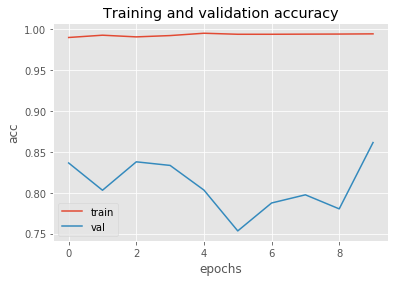

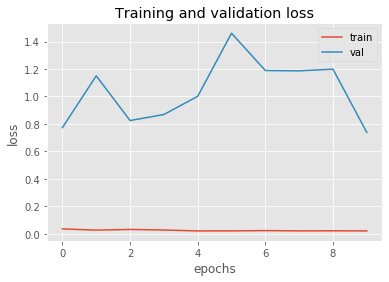

In [91]:
# 1-49

acc = train_history_3.history['accuracy']
val_acc = train_history_3.history['val_accuracy']

loss = train_history_3.history['loss']
val_loss = train_history_3.history['val_loss']

epochs = range(len(acc))

# 繪製準確率
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')

plt.plot(epochs,acc, label='train')
plt.plot(epochs,val_acc,label = 'val')


plt.legend()
plt.show()
plt.clf()


# 繪製損失函數
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')

plt.plot(epochs,loss,label='train')
plt.plot(epochs,val_loss,label='val')

plt.legend()
plt.show()

---

**1.5 評估與測試**

---

In [88]:
# 1-50

# 使用model.evaluate進行評估模型準確率，評估後的準確率會儲存在sorces
# 設定測試資料參數
# 顯示準確率

sorces =  model_3.evaluate ( x_test , y_test , verbose=1 )                                                                        
sorces[1]  

25000/25000 [==============================] - 28s 1ms/step


0.8434799909591675

In [ ]:
# 1-51

# 預測前30筆

predict = model.predict_classes(x_test)
predict[:30]

In [ ]:
# 1-52

predict_classes = predict.reshape(-1)
predict_classes[:10]

In [ ]:
# 1-53
# 定義字典
# 建立函數
# 顯示影評文字

SentimentDict = {1:'正面的',0:'負面的'}  
def display_test_Sentiment(i):  
    print(test_text[i])   
    print ( 'label真實值：' , SentimentDict[y_test[i]] , '預測結果：' , SentimentDict[predict_classes[i]] ) 

In [ ]:
display_test_Sentiment(2)

In [3]:
# 1-54

display_test_Sentiment(20000)

NameError: name 'display_test_Sentiment' is not defined

---

**1.6 建立新的數據集**

---

In [ ]:
# 1-55

input_text = "The popularity and the huge profits of Despicable Me franchise has driven the eagerness of Illumination Entertainment to produce a minions spin-off solely to entertain the fans. Caught in variations of the same scenarios, the decision to put more focus on the three minions - Kevin, Stuart and Bob might remind audiences about Alvin and the Chipmunks or the three daughters of Gru. While the animation does remain the fun, hilarious and ridiculous behaviors of the characters, the theme of the scores and the nonsensical language of the minions, it does not have a strong villain to support the three, also it lacks of character development, warm emotional engagement and moral values. The cuteness of the minions is the main element for entertainment rather than the dialogue itself in which the jokes aren't as funny as Despicable Me's series. Nonetheless, it is still energetic, actions packed, visually stunning and colorful for family audiences even its creative mistake drags its overall quality, proving that these banana lovers are far more effective and surprising to be supporting characters just as in the main franchise."

In [ ]:
# 1-56

input_seq = token.texts_to_sequences([input_text])
print(input_seq[0])

In [ ]:
# 1-57

len(input_seq[0])

In [ ]:
# 1-58
# 100為數字list長度

pad_input_seq = sequence.pad_sequences(input_seq,maxlen=100)  

In [ ]:
len(pad_input_seq[0])

In [ ]:
# 1-59

predict_result = model.predict_classes(pad_input_seq)

In [ ]:
# 1-60

predict_result

In [ ]:
# 1-61

predict_result[0][0]

In [ ]:
# 1-62

SentimentDict[predict_result[0][0]]

In [ ]:
# 1-63
# 100為數字list長度

def predict_review(input_text):
    input_seq = token.texts_to_sequences([input_text])
    pad_input_seq = sequence.pad_sequences(input_seq,maxlen=100)   
    predict_result = model.predict_classes(pad_input_seq)
    print(SentimentDict[predict_result[0][0]])

In [ ]:
# 1-64

predict_review('''Minions isn't as great a story as Despicable Me, but it's definitely a lot of fun. It's just a silly little story, giving some background to the little corn pops.I really had a good time watching it. There's lots of goofy action, and thank god, it wasn't full of stupid bathroom humour. It was actually pretty funny. The kids will like it.My favourite part of the movie was the soundtrack. The movie takes place in the 60s, so the songs comes from that era. It's going to introduce so many kids to a lot of good music, and you can never go wrong with that, especially nowadays.''')


In [ ]:
# 1-65

predict_review('''My seven year old was excited to see it. I expected it to be pish. But it was worse than I imagined. I fell asleep a few times but the annoying yelling pretend dialogue woke me up. I couldn't even get a nap out of my wasted afternoon. At least I didn't have to worry about my kid laughing too loudly and disturbing anyone else's sleep. He got bored too. Just utter crap. They clearly spent a lot on the music. The Beatles, the kinks, and van Halens eruption as a guitar solo at the merciful end to this travesty of a film. If only they had spent the money on a scriptwriter rather than the over- caffeinated sixth graders they got hopped up on juice boxes before handing them some paper to defecate on and call that a script. The humor in the film was non existent. I expected lots of broad fart jokes and low brow stupidity aimed at chimps, five year olds, and the same kind of morons who made Kevin James a star. What I got was obvious pop culture references not as punchlines or set up for jokes. Just there. As if the existence of a reference to something recognizable was in and of itself funny. Perhaps it served as a confidence booster for the gump-like, slack jawed, troglodytes that were the target audience. They could all feel jolly clever after recognizing such obscure references as the Beatles. Well done. If I had a time machine and only choose to change one thing in the pas, forget hitter, I would go back to stop whoever green lit this cinematic excretion.''')


In [ ]:
# 1-66

predict_review('''I attended an advance screening of this film not sure of what to expect from Kevin Costner and Ashton Kutcher; both have delivered less than memorable performances & films. While the underlying "general" storyline is somewhat familiar, this film was excellent. Both Costner and Kutcher delivered powerful performances playing extremely well off each other. The human frailties and strengths of their respective characters were incredibly played by both; the scene when Costner confronts Kutcher with the personal reasons why Kutcher joined the Coast Guard rescue elite was the film's most unforgettable emotional moment. The "specific" storyline was an education in itself depicting the personal sacrifice and demanding physical training the elite Coast Guard rescuers must go through in preparation of their only job & responsibility...to save lives at sea. The special effects of the rescue scenes were extremely realistic and "wowing"...I haven't seen such angry seas since "The Perfect Storm". Co-star Clancy Brown (HBO's "Carnivale" - great to see him again) played the captain of the Coast Guard's Kodiak, Alaska base in a strong, convincing role as a leader with the prerequisite and necessary ice water in his veins. The film wonderfully, and finally, gives long overdue exposure and respect to the Coast Guard; it had the audience applauding at the end.''')

In [ ]:
predict_review('''If you had asked me how the movie was throughout the film, I would have told you it was great! However, I left the theatre feeling unsatisfied. After thinking a little about it, I believe the problem was the pace of the ending. I feel that the majority of the movie moved kind of slow, and then the ending developed very fast. So, I would say the ending left me disappointed.<br /><br />I thought that the characters were well developed. Costner and Kutcher both portrayed their roles very well. Yes! Ashton Kutcher can act! Also, the different relationships between the characters seemed very real. Furthermore,I thought that the different plot lines were well developed. Overall, it was a good movie and I would recommend seeing it.<br /><br />In conclusion: Good Characters, Great Plot, Poorly Written/Edited Ending. Still, Go See It!!!''')